In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy.constants as c
import astropy.units as u
import sys
sys.path.pop(1)
sys.path.insert(0,'../')

In [7]:
import pyathena as pa
import glob,os

In [4]:
units=pa.set_units(muH=1.4271)
Myr=units['time'].to('Myr').value
surf_unit=(units['density']*units['length']).to('Msun/pc^2').value

In [237]:
base='/Users/cgkim/Dropbox/ongoing_work/chiral_structure/'
basedir='/tigress/changgoo/'
id='HD_4pc'
base='%s%s' % (basedir,id)
rstfiles=glob.glob('%s/id0/%s.????.rst' % (base,id))+glob.glob('%s/rst/%s.????.rst' % (base,id))
hstfile='%s/id0/%s.hst' % (base,id)
snfile='%s/id0/%s.sn' % (base,id)


In [238]:
h=pa.hst_reader(hstfile)
sn=pa.hst_reader(snfile)
par,block,field=pa.parse_par(rstfiles[0])

Reading a history file:/tigress/changgoo/HD_4pc/id0/HD_4pc.hst.p
Reading a history file:/tigress/changgoo/HD_4pc/id0/HD_4pc.sn.p


In [239]:
Lx=eval(par['domain1']['x1max'][0])-eval(par['domain1']['x1min'][0])
Ly=eval(par['domain1']['x2max'][0])-eval(par['domain1']['x2min'][0])
Lz=eval(par['domain1']['x3max'][0])-eval(par['domain1']['x3min'][0])
Lz

4096

In [243]:
tmin=np.max([int(h.time.min()),250])
tmax=np.min([int(h.time.max()),500])
print tmax,tmin,tmax-tmin

snrate,tsn=np.histogram(sn.time,bins=tmax-tmin,range=(tmin,tmax))
snrate=snrate/Myr/Lx/Ly
tsn=tsn[:-1]
#tsn=range(tmin,tmax)

427 250 177


In [244]:
sfr10=np.interp(tsn,h.time,h.sfr10)
sfr40=np.interp(tsn,h.time,h.sfr40)
sfr100=np.interp(tsn,h.time,h.sfr100)
surf=np.interp(tsn,h.time,h.mass*Lz*surf_unit)

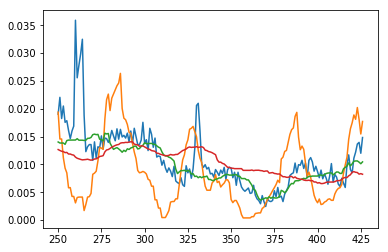

In [245]:
plt.plot(tsn,snrate*100)
plt.plot(tsn,sfr10)
plt.plot(tsn,sfr40)
plt.plot(tsn,sfr100)

In [246]:
vx=np.interp(tsn,h.time,np.sqrt(0.5*h.x1KE_2p/h.mass))
vy=np.interp(tsn,h.time,np.sqrt(0.5*h.x2KE_2p/h.mass))
vz=np.interp(tsn,h.time,np.sqrt(0.5*h.x3KE_2p/h.mass))
vt=np.sqrt(vx**2+vy**2+vz**2)
Hc=np.interp(tsn,h.time,np.sqrt((h.H2c+h.H2u)/h.mass))
Hw=np.interp(tsn,h.time,np.sqrt((h.H2w)/h.mass))

In [247]:
Omega=28.
Q=(vx*np.sqrt(2)*Omega*u.km/u.s/u.kpc*u.km/u.s/np.pi/c.G/(surf*c.M_sun/c.pc**2)).cgs.value

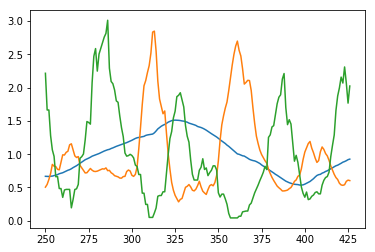

In [248]:

#plt.plot(tsn,vt/vt.mean())
plt.plot(tsn,Hw/Hw.mean())
plt.plot(tsn,Hc/Hc.mean())
plt.plot(tsn,sfr10/sfr10.mean())
#plt.plot(h.time,h.heat_ratio/h.heat_ratio.mean())
#plt.xlim(200,500)

In [249]:
import cPickle as p
p.dump({'time':tsn,'snrate':snrate,'sfr10':sfr10,'sfr40':sfr40,'sfr100':sfr100,'vt':vt,'Hc':Hc,'Hw':Hw},
       open('%s/slice/%s.history.p' % (base,id),'wb'),p.HIGHEST_PROTOCOL)

In [251]:
files=glob.glob('%s/slice/%s.????.slice.p' % (base,id))
if not os.path.isdir('%s/slice/%s_zslices/' % (base,id)): os.mkdir('%s/slice/%s_zslices/' % (base,id))
for t in tsn:
#for f in files:
    f='%s/slice/%s.%04d.slice.p' % (base,id,t)
    f2=f.replace('slice/','slice/%s_zslices/' % id).replace('slice.p','nH.zslice.p')
    if not os.path.isfile(f2):
        slc=p.load(open(f,'rb'))
#    print t, slc['time']/Myr
        p.dump(slc['z']['nH'],open(f2,'wb'),p.HIGHEST_PROTOCOL)

In [252]:
os.chdir('%s/slice' % base)
os.system("tar czvf %s.nH.zslice.tar.gz %s_zslices/" % (id,id))

0

In [253]:
dest='cgkim@antares.astro.princeton.edu:/scr1/cgkim/Dropbox/ongoing_work/chiral_structure/'
os.system("rsync -Cav %s.nH.zslice.tar.gz %s" % (id,dest))
os.system("rsync -Cav %s.history.p %s" % (id,dest))

0